# Sweep N Values

In [1]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy import sin
from numpy import pi
from scipy.optimize import curve_fit
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=20

In [2]:
L=1
J1=1
J2=0.1
JM=max(J2,J1)
Jm=min(J2,J1)
ω=2
U=5
weight=0.01

En estos subalgoritmos definimos los operadores creación y destrucción de bosones:
$$a |n\rangle = \sqrt{n} |n-1\rangle \qquad a^\dagger |n \rangle = \sqrt{n+1} |n+1  \rangle$$

In [3]:
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False, fastmath=True)
def a(n):
    if n == 0:
        return (0,0)
    else:
        return (n-1, np.sqrt(n))

@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False, fastmath=True)
def a_plus(n):
    return (n+1, np.sqrt(n+1))

In [4]:
#Definimos el producto entre un bra y un ket, si son iguales vale 1 y si son distintos 0
@numba.jit(float64(float64[:],float64[:]), nopython = True, parallel = False, fastmath=True)
def bracket(bra1, ket1):
    if np.all(bra1 == ket1):
        return 1
    else:
        return 0

In [5]:
#Este subalgoritmo calcula un elemento de matriz con un Hamiltoniano 
@numba.jit(float64(float64[:],float64[:],float64, int64, float64), nopython = True, parallel = False)
def Elemento_matriz_Hamiltoniano(bra, ket, U, N, ω):
    #print(bra,ket)
    #<bra|H|ket>
    n_eigval=N*(N+1)/2
    H=0

    ket_aux = np.empty(len(ket))
    ket_aux2 = np.empty(len(ket))
    bra_aux = np.empty(len(ket))

    bracket1 = bracket(bra, ket)

    H += np.sum(ω*ket*bracket1)
    H += np.sum(0.5*U*ket*(ket-1)*bracket1)
    
    ket_aux[:] = ket
    ket_aux2[:] = ket
    bra_aux[:] = bra
    if (N-1)%2==0:
        J=-J1
    else:
        J=-J2
    ket_aux[0], coef_term2=0,0
    ket_aux[N-1], coef_term2_aux=a_plus(ket_aux[N-1])
    term2 = J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
    ket_aux2[N-1], coef_term3=a(ket_aux2[N-1])
    #P.B.C.
    #ket_aux2[0], coef_term3_aux=a_plus(ket_aux2[0])
    #H.B.C.
    ket_aux2[0], coef_term3_aux=0,0
    term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
    H+=term2+term3
    for i in range(len(ket)-1):
            ket_aux[:] = ket
            ket_aux2[:] = ket
            bra_aux[:] = bra
            #print("El valor de bra en el subalgoritmo")
            #print(bra)
            #coef_term2=coef_term2_aux=coef_term3=coef_term3_aux=0
            if i%2==0:
                J=-J1
            else:
                J=-J2
            
            #print("Entro en el else")
            ket_aux[i+1], coef_term2 = a(ket_aux[i+1])
            ket_aux[i], coef_term2_aux=a_plus(ket_aux[i])
            term2=J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
            ket_aux2[i], coef_term3=a(ket_aux2[i])
            ket_aux2[i+1], coef_term3_aux=a_plus(ket_aux2[i+1])
            term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)

            #print(term2, term3)
            H+=term2+term3
    #print("\n")
    return H

In [6]:
@numba.jit(float64[:,:](float64,float64[:,:], int64, float64[:,:]), nopython = True, parallel = False)
def ComputeH(U,base, N, ω_matrix):
    n_eigval=int(N*(N+1)/2)
    H = np.empty((n_eigval,n_eigval))
    for i2 in range(n_eigval):
        for j2 in range(n_eigval):
            H[i2,j2]=Elemento_matriz_Hamiltoniano(base[i2],base[j2], U, N, ω_matrix[i2, j2])
    return H

In [7]:
@numba.jit(float64[:, :](int64, float64, float64, float64[:]), nopython=True, parallel=False)
def FastHamiltonian(N, J1, J2, ω_array):
    #Manera rapida de calcular el Hamiltoniano
    aux_N=int(N/2) #Numero de celdas
    H_int1=np.asarray([[0, 1], [1, 0]])
    aux1=np.kron(np.eye(aux_N), H_int1)
    aux2=np.eye(N, k=1)+np.eye(N, k=-1)-aux1
    aux3=np.zeros((N, N))
    for i in range(N):
        aux3[i, i]=ω_array[i]
    H=J1*aux1+J2*aux2+aux3
    #print(H)
    return H

In [8]:
@numba.jit(numba.types.Tuple((int64[:], int64[:], int64[:], float64[:]))(int64, float64[:]), fastmath=True,  nopython = True, parallel = False)
def ComputeIndexes(N, ω_array):    
    H1p=FastHamiltonian(N, J1, J2, ω_array)
    eigval1p, eigvect1p=eig(H1p)
    idx1p = np.argsort(eigval1p)
    eigval1p = eigval1p[idx1p]
    eigvalNeg=eigval1p[:int(N/2)]
    InterestingIndex=np.argmax(eigvalNeg)
    E_teorIndep=[]
    NumberIterations=0
    IndexEdgeEdge=[]
    IndexBulkEdge=[]
    counter=0
    #Edge_Edge_Energies=[2*eigval1p[InterestingIndex], eigval1p[InterestingIndex]+ eigval1p[InterestingIndex+1], 2*eigval1p[InterestingIndex+1]]
    for i in range(N):
        for j in range (i,N):
            E_teorIndep.append(eigval1p[i]+eigval1p[j])
            if i== InterestingIndex or i==InterestingIndex+1:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexEdgeEdge.append(counter)
                else:
                    IndexBulkEdge.append(counter)
            else:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexBulkEdge.append(counter)
            counter+=1
    E_teorIndep=np.asarray(E_teorIndep)
    idx=np.argsort(E_teorIndep)
    E_teorIndep=E_teorIndep[idx]
    for i in range(len(IndexEdgeEdge)):
        IndexEdgeEdge[i]=np.argmin(np.abs(idx-IndexEdgeEdge[i]))
    for i in range(len(IndexBulkEdge)):
        IndexBulkEdge[i]=np.argmin(np.abs(idx-IndexBulkEdge[i]))
    IndexBulkBulk=[]
    for k in range(len(E_teorIndep)):
        if k in IndexBulkEdge :
            dummy=1
        elif k in IndexEdgeEdge:
            dummy=2
        else:
            IndexBulkBulk.append(k)
    IndexEdgeEdge=np.asarray(IndexEdgeEdge)
    IndexBulkEdge=np.asarray(IndexBulkEdge)
    IndexBulkBulk=np.asarray(IndexBulkBulk)
    #print(IndexBulkBulk, IndexBulkEdge, IndexEdgeEdge)
    #print(out)
    return (IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep)
#ComputeIndexes(10)

In [9]:
@numba.jit(numba.types.UniTuple(float64[:],2)(float64[:,:]), nopython = True, parallel = False, fastmath=True)
def ComputeParticipationRatio(H):
    #H=Matrix(n_eigval, n_eigval, func_aux)
    #display(H)
    #H=np.array(H).astype(np.float64)
    #eigval, eigvect = np.linalg.eig(H)
    eigval, eigvect = np.linalg.eig(H.astype(np.complex128))
    eigval = np.real(eigval)
    idx = np.argsort(eigval)
    eigval=eigval[idx]
    #eigval = list(eigval[idx])
    #No sé cual ess la forma buena
    eigvect = eigvect[:,idx]
    participation_ratio = np.sum(np.abs(eigvect**2), axis = 0) / np.sum(np.abs(eigvect**4), axis = 0)
    #print("PR")
    #print(participation_ratio)
    #if SweepU:
        #return np.amin(participation_ratio)
    #if SweepN:
    return eigval, participation_ratio


@numba.jit(numba.types.UniTuple(float64[:], 7)(int64,int64,int64, float64), nopython = True, fastmath=True,  parallel =False)
def SweepNSubalg(N_min, N_max, salto, U):

    N_array=np.arange(N_min,N_max,salto)
    N_points=len(N_array)
    AvBD=np.zeros((N_points))
    SiBD=np.zeros((N_points))
    AvS=np.zeros((N_points))
    SiS=np.zeros((N_points))
    Av2S=np.zeros((N_points))
    Si2S=np.zeros((N_points))
    AvBE=np.zeros((N_points))
    SiBE=np.zeros((N_points))
    Av2BD=np.zeros((N_points))
    Si2BD=np.zeros((N_points))
    MinBD=np.zeros((N_points))
    MinS=np.zeros((N_points))
    Min2BD=np.zeros((N_points))
    """AverageDoublon=np.zeros((N_points))
    SigmaScatt=np.zeros((N_points))
    AverageScatt.zeros((N_points))
    SigmaDoublon=np.zeros((N_points))
    AverageBE=np.zeros((N_points))
    SigmaBE=np.zeros((N_points))
    AverageEE=np.zeros((N_points))
    SigmaEE=np.zeros((N_points))
    AverageBB=np.zeros((N_points))
    SigmaBB=np.zeros((N_points))"""
    for m in range(N_points):
        n=N_array[m]
        PR_array=np.zeros(n)
        eigval=np.zeros(n)
        n_eigval=int(n*(n+1)/2)
        SweepNMatrix = np.zeros((n_eigval,n_eigval))
        #print(n)
        Identity=np.identity(n)
        base=np.empty((n_eigval, n))
        counter=0
        for l in range(n):
            for k in range(l,n):
                ketB=Identity[k,:]+Identity[l,:]
                #print(ketB)
                base[counter, :]=ketB
                counter+=1
        #base=base.astype('int64')
        #print(base)
        if ω==0:
             ω_array=(2*weight*(np.random.rand(n)-0.5))
        else:
            ω_array=ω*(1+2*weight*(np.random.rand(n)-0.5))
        ω_matrix=np.zeros((n_eigval, n_eigval))
        counter=0
        for l in range(n):
            for k in range(l,n):
                ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])/2
                counter+=1
        SweepNMatrix=ComputeH(U, base, n, ω_matrix)
        eigval, PR_array=ComputeParticipationRatio(SweepNMatrix)
        eigval-=2*ω
        ScatteringIndex=[]
        ScatteringIndex2=[]
        #BEIndex=[]
        DoublIndex=[]
        UnstDoublIndex=[]
        for i in range(len(eigval)):
            if (eigval[i]>=-2*JM-2*Jm-0.05)&(eigval[i]<=-2*JM+2*Jm+0.05):
                ScatteringIndex.append(i)
            elif (eigval[i]>=-2*Jm-0.05)&(eigval[i]<=2*Jm+0.05):
                ScatteringIndex2.append(i)
            elif (eigval[i]>=-2*Jm+2*JM-0.05)&(eigval[i]<=2*JM+2*Jm+0.05):
                ScatteringIndex.append(i)
            elif (eigval[i]>0):
                DoublIndex.append(i)
            elif(eigval[i]<0):
                UnstDoublIndex.append(i)
            """ elif (eigval[i]>=-J1+J2-0.05)&(eigval[i]<=J2+J1+0.05):
                BEIndex.append(i)
            elif (eigval[i]>=-J1-J2-0.05)&(eigval[i]<=-J2+J1+0.05):
                BEIndex.append(i)"""

        ScattIndex=np.asarray(ScatteringIndex)
        ScattIndex2=np.asarray(ScatteringIndex2)
        #BEdgeIndex=np.asarray(BEIndex)
        DoublonIndex=np.asarray(DoublIndex)
        UnstDoublonIndex=np.asarray(UnstDoublIndex)
        AvBD[m]=np.mean(PR_array[DoublonIndex])
        SiBD[m]=np.std(PR_array[DoublonIndex])
        #AvS[m]=np.mean(PR_array[ScattIndex])
        #SiS[m]=np.std(PR_array[ScattIndex])
        #Av2S[m]=np.mean(PR_array[ScattIndex2])
        #Si2S[m]=np.std(PR_array[ScattIndex2])
        #AvBE[m]=np.mean(PR_array[BEdgeIndex])
        #SiBE[m]=np.std(PR_array[BEdgeIndex])
        Av2BD[m]=np.mean(PR_array[UnstDoublonIndex])
        Si2BD[m]=np.std(PR_array[UnstDoublonIndex])
        MinBD[m]=np.min(PR_array[DoublonIndex])
        #print(DoublonIndex[np.argmin(PR_array[DoublonIndex])])
        MinS[m]=np.min(PR_array[ScattIndex2])
        Min2BD[m]=np.min(PR_array[UnstDoublonIndex])
        #IndexEdgeEdgeN, IndexBulkEdgeN, IndexBulkBulkN, trash=ComputeIndexes(n, ω_array)
        #IndexDoublon=np.arange(int(n*(n+1)/2)-n, int(n*(n+1)/2))
        #IndexScattering=np.arange(0, int(n*(n+1)/2)-n)
        #print(IndexEdgeEdgeN, IndexBulkEdgeN, IndexBulkBulkN)
        """AverageEE[i]=np.mean(PR_array[IndexEdgeEdgeN])
        SigmaEE[i]=np.std(PR_array[IndexEdgeEdgeN])
        AverageBE[i]=np.mean(PR_array[IndexBulkEdgeN])
        SigmaBE[i]=np.std(PR_array[IndexBulkEdgeN])
        AverageBB[i]=np.mean(PR_array[IndexBulkBulkN])
        SigmaBB[i]=np.std(PR_array[IndexBulkBulkN])
        
        AverageDoublon[i]=(np.mean(PR_array[IndexDoublon]))
        SigmaDoublon[i]=(np.std(PR_array[IndexDoublon]))
        MeanScattering[i]=np.mean(PR_array[IndexScattering])
        SigmaScatt[i]=np.std(PR_array[IndexScattering])"""
        #print(AverageBulkBulk, AverageBulkEdge, MinBulkBulk, MaxEdgeEdge, MinEdgeEdge)
    return(AvBD, SiBD, Av2BD, Si2BD, MinBD, Min2BD, MinS)
    #print(AverageBulkBulk)
    #return (AvBD, SiBD, AvS, SiS, AvBE, SiBE, Av2BD, Si2BD, MinBD, MinS, Min2BD, Av2S, Si2S)
    #return (AverageDoublon, SigmaDoublon, MeanScattering, SigmaScatt)
    #return(AverageEE, SigmaEE, AverageBE, SigmaBE, AverageBB, SigmaBB)
      
    

In [10]:
N_min=10
N_max=20
deltaN=2
N_array=np.arange(N_min, N_max, deltaN)
#print(N_array)
#AverageEE, SigmaEE, AverageBE, SigmaBE, AverageBB, SigmaBB=SweepNSubalg(N_min, N_max, deltaN, U) 
#AverageDoublon, SigmaDoublon, MeanScattering, SigmaScatt=SweepNSubalg(N_min, N_max, deltaN, U)
#AvBD, SiBD, AvS, SiS, AvBE, SiBE, Av2BD, Si2BD, MinBD, MinS, Min2BD, Av2S, Si2S=SweepNSubalg(N_min, N_max, deltaN, U)
AvBD, SiBD, Av2BD, Si2BD, MinBD, Min2BD, MinS=SweepNSubalg(N_min, N_max, deltaN, U)
print("Todo salio bien mi pana")
"""fig=plt.figure(figsize=[12, 9])
plt.errorbar(N_array, AverageDoublon, yerr=SigmaDoublon, color='red', capsize=5, linestyle='None')
plt.scatter(N_array, AverageDoublon, color='red', label="Average of Doublon Band")
plt.errorbar(N_array, AvScatt, yerr=SigmaScatt, color='blue', capsize=5, linestyle='None')
plt.scatter(N_array, AvScatt, color='blue', label='Average of Scattering states')
plt.legend()
plt.xlabel("Number of sites")
plt.ylabel("PR")
#plt.yscale('log')
#plt.xscale('log')
plt.show()"""

Todo salio bien mi pana


'fig=plt.figure(figsize=[12, 9])\nplt.errorbar(N_array, AverageDoublon, yerr=SigmaDoublon, color=\'red\', capsize=5, linestyle=\'None\')\nplt.scatter(N_array, AverageDoublon, color=\'red\', label="Average of Doublon Band")\nplt.errorbar(N_array, AvScatt, yerr=SigmaScatt, color=\'blue\', capsize=5, linestyle=\'None\')\nplt.scatter(N_array, AvScatt, color=\'blue\', label=\'Average of Scattering states\')\nplt.legend()\nplt.xlabel("Number of sites")\nplt.ylabel("PR")\n#plt.yscale(\'log\')\n#plt.xscale(\'log\')\nplt.show()'

In [11]:
"""fig=plt.figure(figsize=[12, 9])
plt.errorbar(N_array, AvBD, yerr=SiBD, color='cyan', capsize=5, linestyle='None')
plt.scatter(N_array, AvBD, color='cyan', label="Average of Doublon Band")
plt.errorbar(N_array, Av2BD, yerr=Si2BD, color='yellow', capsize=5, linestyle='None')
plt.scatter(N_array, Av2BD, color='yellow', label="Average of 2 Doublon Band")
plt.errorbar(N_array, AvS, yerr=SiS, color='red', capsize=5, linestyle='None')
plt.scatter(N_array, AvS, color='red', label='Average of Scattering states')
plt.errorbar(N_array, Av2S, yerr=Si2S, color='purple', capsize=5, linestyle='None')
plt.scatter(N_array, Av2S, color='purple', label='Average of Intermediate Scattering Band')
plt.errorbar(N_array, AvBE, yerr=SiBE, color='black', capsize=5, linestyle='None')
plt.scatter(N_array, AvBE, color='black', label="Average of Bulk-Edge Band")
plt.scatter(N_array, MinBD, color='blue', label="Minimum of Doublon Band", marker='x')
plt.scatter(N_array, Min2BD, color='magenta', label="Minimum of 2 Doublon Band", marker='x')
plt.scatter(N_array, MinS, color='green', label='Minimum of Scattering Band', zorder=0)
plt.legend(labelspacing=0, handletextpad=0, framealpha=0.4)
plt.xlabel("N")
plt.ylabel("PR(N)")
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.7,)
plt.show()"""
"""fig=plt.figure(figsize=[12, 9])
plt.errorbar(N_array, AverageDoublon, yerr=SigmaDoublon, color='red', capsize=5, linestyle='None')
plt.scatter(N_array, AverageDoublon, color='red', label="Average of Doublon Band")
plt.errorbar(N_array, MeanScattering, yerr=SigmaScatt, color='blue', capsize=5, linestyle='None')
plt.scatter(N_array, MeanScattering, color='blue', label='Average of Scattering states')
plt.legend()
plt.xlabel("Number of sites")
plt.ylabel("PR")
plt.yscale('log')
plt.xscale('log')
plt.show()"""

'fig=plt.figure(figsize=[12, 9])\nplt.errorbar(N_array, AverageDoublon, yerr=SigmaDoublon, color=\'red\', capsize=5, linestyle=\'None\')\nplt.scatter(N_array, AverageDoublon, color=\'red\', label="Average of Doublon Band")\nplt.errorbar(N_array, MeanScattering, yerr=SigmaScatt, color=\'blue\', capsize=5, linestyle=\'None\')\nplt.scatter(N_array, MeanScattering, color=\'blue\', label=\'Average of Scattering states\')\nplt.legend()\nplt.xlabel("Number of sites")\nplt.ylabel("PR")\nplt.yscale(\'log\')\nplt.xscale(\'log\')\nplt.show()'

ValueError: x and y must be the same size

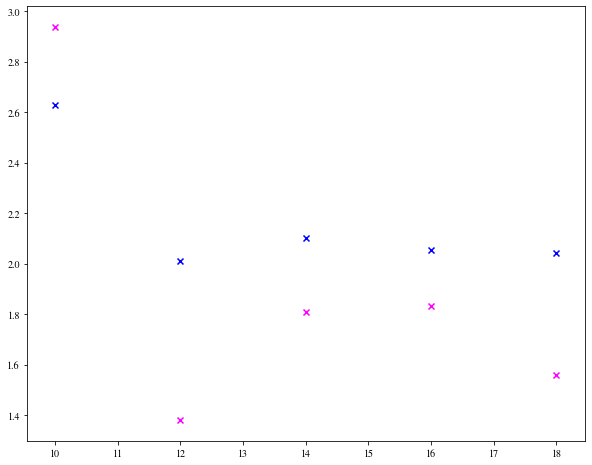

In [12]:
#np.savetxt("PRN_2pSSH_Data.txt", np.column_stack([AvBD, SiBD, Av2BD, Si2BD, MinBD, MinS, Min2BD]))
TAvBD, TSiBD, TAv2BD, TSi2BD, TMinBD, TMinS, TMin2BD=np.loadtxt("PRN_2pSSH_Data.txt", unpack=True)
plt.figure(figsize=[10,8])
#plt.errorbar(N_array, AvBD, yerr=SiBD, color='cyan', capsize=5, linestyle='None')
#plt.scatter(N_array, AvBD, color='cyan', label="Average of Doublon Band", marker="D")
#plt.errorbar(N_array, Av2BD, yerr=Si2BD, color='yellow', capsize=5, linestyle='None')
#plt.scatter(N_array, Av2BD, color='yellow', label="Average of 2 Doublon Band", marker="D")
plt.scatter(N_array, MinBD, color='blue', label="Trivial Phase: Minimum of H.E. Doublon Band", marker="x")
plt.scatter(N_array, Min2BD, color='magenta', label="Trivial Phase: Minimum of L.E. Doublon Band", marker="x")
#plt.errorbar(N_array, TAvBD, yerr=TSiBD, color='cyan', capsize=5, linestyle='None')
#plt.scatter(N_array, TAvBD, color='cyan', label="Average of Doublon Band", marker='X')
#plt.errorbar(N_array, TAv2BD, yerr=Si2BD, color='yellow', capsize=5, linestyle='None')
#plt.scatter(N_array, TAv2BD, color='yellow', label="Average of 2 Doublon Band", marker='X')
plt.scatter(N_array, TMinBD, color='blue', label="Topological Phase: Minimum of H.E. Doublon Band ")
plt.scatter(N_array,TMin2BD, color='magenta', label="Topological Phase: Minimum of L.E. Doublon Band ")
plt.scatter(N_array, TMinS, color='green', label='Topological Phase: Minimum of Scattering Band')
plt.legend(labelspacing=0)
plt.xlabel("Number of sites")
plt.ylabel("PR")
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [ ]:
def func(N, a, b, c):
    return a*N**2+b*N+c
#AvScatt=MeanScattering
#poptBB, pcovBB=curve_fit(func, N_array, AverageDoublon,p0=[1,1,0], sigma=SigmaDoublon)
#poptBE, pcovBE=curve_fit(func, N_array, AvScatt,p0=[1,1,0], sigma=SigmaScatt)
poptS, pcovS=curve_fit(func, N_array, AvS, p0=[1,1,0], sigma=SiS)
popt2S, pcov2S=curve_fit(func, N_array, Av2S, p0=[1,1,0], sigma=Si2S)
poptBE, pcovBE=curve_fit(func, N_array, AvBE, p0=[0,1,1], sigma=SiBE)
poptBD, pcovBD=curve_fit(func, N_array, AvBD, p0=[0,0,1], sigma=SiBD)
popt2BD, pcov2BD=curve_fit(func, N_array, Av2BD, p0=[0,0,1], sigma=Si2BD)
poptED, pcovED=curve_fit(func, N_array, MinBD, p0=[0,0,1])
poptQED, pcovQED=curve_fit(func, N_array, Min2BD, p0=[0,0,1])
poptSE, pcovSE=curve_fit(func, N_array, MinS, p0=[0,0,1])
"""poptBB, pcovBB=curve_fit(func, N_array, AverageBB,p0=[1,1,0], sigma=SigmaBB)
poptBE, pcovBE=curve_fit(func, N_array, AverageBE,p0=[1,1,0], sigma=SigmaBE)
poptEE, pcovEE=curve_fit(func, N_array, AverageEE,p0=[1,1,0], sigma=SigmaEE)

print("Quadratic Fit to the average Doublon PR values aN^2+bN+c with errors")
print("a \t \t b \t \t  c")
print(poptBB)
print(np.sqrt(pcovBB[0,0]), np.sqrt(pcovBB[1, 1]), np.sqrt(pcovBB[2, 2]))
print("\n Quadratic Fit to the average Scattering PR values aN^2+bN+c with errors")
print("a \t \t b \t \t  c")
print(poptBE)
print(np.sqrt(pcovBE[0,0]), np.sqrt(pcovBE[1, 1]), np.sqrt(pcovBE[2, 2]))
print("\n Quadratic Fit to the average edge-edge PR values aN^2+bN+c with errors")
print("a \t \t b \t \t  c")
print(poptEE)
print(np.sqrt(pcovEE[0,0]), np.sqrt(pcovEE[1, 1]), np.sqrt(pcovEE[2, 2]))
np.savetxt('dataStrange.txt', np.column_stack((AverageBulkBulk, MinBulkBulk, AverageBulkEdge, MaxEdgeEdge, MinEdgeEdge)), delimiter=' ')

fig=plt.figure()
plt.errorbar(N_array, AverageBB, yerr=SigmaBB, color='red', capsize=5, linestyle='None')
plt.errorbar(N_array, AverageBE, yerr=SigmaBE, color='black', capsize=5, linestyle='None')
plt.errorbar(N_array, AverageEE, yerr=SigmaEE, color='blue', capsize=5, linestyle='None')
plt.scatter(N_array, AverageBB, s=10,color='red', label="Bulk-Bulk States")
plt.scatter(N_array, AverageBE, s=10, color='black', label="Bulk-Edge States")
plt.scatter(N_array, AverageEE, s=10, color='blue', label="Edge-Edge States")
plt.plot(N_array, func(N_array, poptBB[0], poptBB[1], poptBB[2]), color='red')
plt.plot(N_array, func(N_array, poptBE[0], poptBE[1], poptBE[2]), color='black')
plt.plot(N_array, func(N_array, poptEE[0], poptEE[1], poptEE[2]), color='blue')
plt.legend()
plt.xlabel("N", size=15)
plt.ylabel("PR", size=15)
#plt.title("Fit of the PR values versus the number of sites for ω="+str(ω)+" with a perturbation of Δω="+str(weight*100)+"% \n with J1="+str(J1)+" J2="+str(J2)+" and U="+str(U))
plt.savefig('SSH_FitPRvsN.png')
plt.yscale('log')
plt.xscale('log')
plt.show()

fig=plt.figure(figsize=[7,5])
plt.errorbar(N_array, AvScatt, yerr=SigmaScatt, color='blue', capsize=5, linestyle='None')
plt.scatter(N_array, AvScatt, color='blue', label='Scattering states')
plt.errorbar(N_array, AverageDoublon, yerr=SigmaDoublon, color='red', capsize=5, linestyle='None')
plt.scatter(N_array, AverageDoublon, color='red', label="Doublons")
plt.plot(N_array, func(N_array, poptBB[0], poptBB[1], poptBB[2]), color='red')
plt.plot(N_array, func(N_array, poptBE[0], poptBE[1], poptBE[2]), color='blue')
plt.legend()
plt.xlabel("Number of sites")
plt.ylabel("PR")
plt.yscale('log')
plt.xscale('log')
plt.show()
"""
fig=plt.figure(figsize=[12, 9])
plt.errorbar(N_array, AvBD, yerr=SiBD, color='cornflowerblue', capsize=5, linestyle='None')
plt.scatter(N_array, AvBD, color='cornflowerblue', label="Average of High Energy Doublon Bands")
#plt.plot(N_array, func(N_array, poptBD[0], poptBD[1], poptBD[2]), color='cornflowerblue')
plt.errorbar(N_array, Av2BD, yerr=Si2BD, color='orangered', capsize=5, linestyle='None')
plt.scatter(N_array, Av2BD, color='orangered', label="Average of Low Energy Doublon Band")
#plt.plot(N_array, func(N_array, popt2BD[0], popt2BD[1], popt2BD[2]), color='orangered')
plt.errorbar(N_array, AvS, yerr=SiS, color='red', capsize=5, linestyle='None')
plt.scatter(N_array, AvS, color='red', label='Average of Scattering Bands 1 & 3')
plt.errorbar(N_array, Av2S, yerr=Si2S, color='purple', capsize=5, linestyle='None')
plt.plot(N_array, func(N_array, poptS[0], poptS[1], poptS[2]), color='red')
plt.scatter(N_array, Av2S, color='purple', label='Average of Intermediate Scattering Band')
plt.plot(N_array, func(N_array, popt2S[0], popt2S[1], popt2S[2]), color='purple')
plt.errorbar(N_array, AvBE, yerr=SiBE, color='black', capsize=5, linestyle='None')
plt.plot(N_array, func(N_array, poptBE[0], poptBE[1], poptBE[2]), color='black')
plt.scatter(N_array, AvBE, color='black', label="Average of Bulk-Edge Band")
plt.scatter(N_array, MinBD, color='blue', label="Minimum of H.E. Doublon Band", marker='x')
#plt.plot(N_array, func(N_array, poptED[0], poptED[1], poptED[2]), color='blue')
plt.scatter(N_array, Min2BD, color='magenta', label="Minimum of L.E. Doublon Band", marker='x')
#plt.plot(N_array, func(N_array, poptQED[0], poptQED[1], poptQED[2]), color='magenta')
plt.scatter(N_array, MinS, color='green', label='Minimum of Scattering Band', zorder=0)
#plt.plot(N_array, func(N_array, poptSE[0], poptSE[1], poptSE[2]), color='green')
plt.legend(labelspacing=0, handletextpad=0, framealpha=0.4)
plt.xlabel("N")
plt.ylabel("PR(N)")
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.7,)
plt.show()
print("Scattering")
print("a \t \t b \t \t  c")
print(poptS)
print(np.sqrt(pcovS[0,0]), np.sqrt(pcovS[1, 1]), np.sqrt(pcovS[2, 2]))
print("Scattering 2")
print("a \t \t b \t \t  c")
print(popt2S)
print(np.sqrt(pcov2S[0,0]), np.sqrt(pcov2S[1, 1]), np.sqrt(pcov2S[2, 2]))
print("BUlk Edge")
print("a \t \t b \t \t  c")
print(poptBE)
print(np.sqrt(pcovBE[0,0]), np.sqrt(pcovBE[1, 1]), np.sqrt(pcovBE[2, 2]))
print("BUlk Doublon")
print("a \t \t b \t \t  c")
print(poptBD)
print(np.sqrt(pcovBD[0,0]), np.sqrt(pcovBD[1, 1]), np.sqrt(pcovBD[2, 2]))
print("Low energy BUlk Doublon")
print("a \t \t b \t \t  c")
print(popt2BD)
print(np.sqrt(pcov2BD[0,0]), np.sqrt(pcov2BD[1, 1]), np.sqrt(pcov2BD[2, 2]))
print("Edge Doublon")
print("a \t \t b \t \t  c")
print(poptED)
print(np.sqrt(pcovED[0,0]), np.sqrt(pcovED[1, 1]), np.sqrt(pcovED[2, 2]))
print("quasiEdge Doublon")
print("a \t \t b \t \t  c")
print(poptQED)
print(np.sqrt(pcovQED[0,0]), np.sqrt(pcovQED[1, 1]), np.sqrt(pcovQED[2, 2]))
print("\nScattering edge")
print("a \t \t b \t \t  c")
print(poptSE)
print(np.sqrt(pcovSE[0,0]), np.sqrt(pcovSE[1, 1]), np.sqrt(pcovSE[2, 2]))


In [ ]:
print(MinBulkBulk)

In [ ]:
"""BigArray=[]
a=np.asarray([[1, 0], [0, 1]])
b=np.asarray([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
BigArray.append(a)
BigArray.append(b)
BigArray=np.asarray(BigArray)
print(BigArray[0])"""

In [ ]:
#print(AverageBulkBulk, SigmaBB)
#print(AverageBulkEdge, SigmaBE)
print(AverageEdgeEdge, SigmaEE)

In [ ]:
""" N_array=np.arange(N_min,N_max,salto)
    N_points=len(N_array)
    AverageBulkBulk=np.zeros((N_points))
    AverageBulkEdge=np.zeros((N_points))
    AverageEdgeEdge=np.zeros((N_points))
    SigmaBB=np.zeros((N_points))
    SigmaBE=np.zeros((N_points))
    SigmaEE=np.zeros((N_points))
    for i in range(N_points):
        n=N_array[i]
        PR_array=np.zeros(n)
        n_eigval=int(n*(n+1)/2)
        SweepNMatrix = np.zeros((n_eigval,n_eigval))
        #print(n)
        Identity=np.identity(n)
        base=np.empty((n_eigval, n))
        counter=0
        for l in range(n):
            for k in range(l,n):
                ketB=Identity[k,:]+Identity[l,:]
                #print(ketB)
                base[counter, :]=ketB
                counter+=1
        #base=base.astype('int64')
        #print(base)
        ω_array=ω*(1+2*weight*(np.random.rand(n)-0.5))
        ω_matrix=np.zeros((n_eigval, n_eigval))
        counter=0
        for l in range(n):
            for k in range(l,n):
                ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])/2
                counter+=1
        SweepNMatrix=ComputeH(U, base, n, ω_matrix)
        PR_array=ComputeParticipationRatio(SweepNMatrix)
        IndexEdgeEdgeN, IndexBulkEdgeN, IndexBulkBulkN, trash=ComputeIndexes(n, ω_array)
        #print(IndexEdgeEdgeN, IndexBulkEdgeN, IndexBulkBulkN)
        AverageBulkBulk[i]=np.mean(PR_array[IndexBulkBulkN])
        SigmaBB[i]=np.std(PR_array[IndexBulkBulkN])
        AverageBulkEdge[i]=(np.mean(PR_array[IndexBulkEdgeN]))
        SigmaBE[i]=(np.std(PR_array[IndexBulkEdgeN]))
        AverageEdgeEdge[i]=np.mean(PR_array[IndexEdgeEdgeN])
        SigmaEE[i]=np.std(PR_array[IndexEdgeEdgeN])
        #print(AverageBulkBulk, AverageBulkEdge, MinBulkBulk, MaxEdgeEdge, MinEdgeEdge)
    #print(AverageBulkBulk)
    return (AverageBulkBulk, SigmaBB, AverageBulkEdge, SigmaBE, AverageEdgeEdge, SigmaEE)
    """